In this notebook, we will be taking a different approach to looking at extinction. Here, we'll rescue a group of individuals that are at a critical density and look to see if genetic diversity can be recovered within this population. 

To model this, we'll assign a linear vector of SNPs to each individual. Each element in the vector is 0, 1, or 2 which corresponds to the number of mutant polymorphisms in the genome at that position. For example, if we have a G -> A mutation, we would put 0 for GG, 1 for GA or AG, or 2 for AA. This linear vector is based on a pair of binary vectors of the same length, which determines whether that SNP is the mutant on a specific homolog. The 0, 1, 2 vector is obviously calculated then by element-wise adding the two vectors.

Thus, a population can be modeled as a matrix. The model will randomly generate a matrix or take in an input matrix from the user. What it needs to take in, however, is either a distance array or an LD array. For $n$ SNPs, this means an $n-1$ length vector of either base pair distances or LD values between the SNPs. That is, the 0th element of the linkage array corresponds to the linkage between the 0th and 1st SNPs. 

New individuals are created by choosing two individuals. For each parent, we 50/50 start with one of the two homologs, then pick the next mutant based on the provided distance/linkage disequilibrium. This goes until the end of the vector. The two vectors are then combined to make the new individual.

We assume no other mutations, and that all parents die after each reproduction period, so all new individuals in the next generation are good. We also assume linear growth from provided critical number to provided thriving population number, but a critical assumption here is that one new individual is created per generation. This reflects (often) low reproduction rates with many endangered species, especially larger animals and mammals. 

In [25]:
import numpy as np
import matplotlib.pyplot as plt

In [26]:
def simulate_genetic_recovery(n_init,
                              n_thriving,
                              num_snps,
                              ld_array = None,
                              dist_array = None,
                              snp_mats = None):
    """
    Simulates a model of genetic recovery, where we start with a population of n_init and add one new individual
    until we reach n_thriving. The new individual's genotype is determined with probabilities based on the 
    provided LD or distance array. 

    Inputs:
    n_init: int, initial population size
    n_thriving: int, target population size
    num_snps: int, number of SNPs
    ld_array: 1D array of length num_snps-1, optional. This array contains the pairwise LD values between the SNPs.
    dist_array: 1D array of length num_snps-1, optional. This array contains the pairwise distances between the SNPs in megabases, or centimorgans.
        Note that one of ld_array or dist_array must be provided, and if both are, ld_array will be used.
    snp_mats: Array of 2D-arrays, optional. The number of 2D arrays must be equal to n_init. 
        Each 2D array must have shape (2, num_snps); each row is binary and contains the genotype of the individual on the paternal
        or maternal chromosome. It doesn't particularly matter which is which, but the first row is assumed to be the paternal chromosome.
        If this is not provided, the function will generate random genotypes for the initial population.

    Returns:
    snp_mats: Array of 2D-arrays. The number of 2D arrays is equal to n_thriving. 
        Each 2D array has shape (2, num_snps); each row is binary and contains the genotype of the individual on the paternal
        or maternal chromosome. It doesn't particularly matter which is which, but the first row is assumed to be the paternal chromosome.
    allele_freqs: a 2D array of shape (num_gens, num_snps). Each row is the allele frequency of the mutant SNPs in the population at that generation.
        The first row is the initial population, and the last row is the final population.
    """

    #first: one of ld_array or dist_array must be provided
    if ld_array is None and dist_array is None:
        raise ValueError("Either ld_array or dist_array must be provided")
    
    #second: if snp_mats is not provided, generate random genotypes for the initial population
    if snp_mats is None:
        snp_mats = generate_random_genos(n_init, num_snps)
    elif len(snp_mats) != n_init:
        raise ValueError("The number of provided SNP matrices must be equal to n_init")
    elif snp_mats[0].shape[1] != num_snps:
        raise ValueError("The number of SNPs in the provided SNP matrices must be equal to num_snps")
    elif len(snp_mats[0]) != 2:
        raise ValueError("Each SNP matrix must have shape (2, num_snps)")
    
    probs = None
    #third: if ld_array is provided, check that it has the correct length; if it does, convert to probabilities
    if ld_array is not None:
        if len(ld_array) != num_snps - 1:
            raise ValueError("The length of ld_array must be equal to num_snps - 1")
        else:
            probs = convert_ld_to_probs(ld_array)

    #fourth: if dist_array is provided, check that it has the correct length; if it does, convert to probabilities
    if dist_array is not None:
        if len(dist_array) != num_snps - 1:
            raise ValueError("The length of dist_array must be equal to num_snps - 1")
        else:
            probs = convert_dist_to_probs(dist_array)

    allele_freqs = []
    allele_freqs.append(calculate_allele_freqs(snp_mats))

    for i in range(n_init, n_thriving):
        next_gen = []
        for j in range(i + 1):
            #pick two random individuals from the population
            ind1 = np.random.randint(0, len(snp_mats))
            ind2 = np.random.randint(0, len(snp_mats))
            while ind1 == ind2:
                ind2 = np.random.randint(0, len(snp_mats)) #ensure they are different
        
            #using these, reproduce a new individual
            new_ind = generate_new_ind(snp_mats[ind1], snp_mats[ind2], probs)

            #add the new individual to the population
            next_gen.append(new_ind)

        snp_mats = next_gen
        #calculate the allele frequencies
        allele_freqs.append(calculate_allele_freqs(snp_mats))
        #print the current population size
        #print("Current population size: ", len(snp_mats))

    return snp_mats, np.array(allele_freqs)

#helper function: given a SNP matrix, calculate the allele frequencies
def calculate_allele_freqs(snp_mats):
    allele_freqs = np.zeros(snp_mats[0].shape[1]) #1D array of length num_snps
    for i in range(len(snp_mats)):
        for j in range(snp_mats[i].shape[1]):
            allele_freqs[j] += np.sum(snp_mats[i][:, j]) / (2 * len(snp_mats))

    return allele_freqs

#helper function: generate random genotypes, given n_init and num_snps
def generate_random_genos(n_init, num_snps):
    snp_mats = []
    for i in range(n_init):
        snp_mat = np.random.randint(0, 2, size=(2, num_snps))
        snp_mats.append(snp_mat)
    return snp_mats

#helper function: given an LD array, convert to probabilities
#for simplicity: anything above 0.5 is kept as the original, and anything below is raised to 0.5
def convert_ld_to_probs(ld_array):
    probs = np.zeros(len(ld_array))
    for i in range(len(ld_array)):
        if ld_array[i] > 0.5:
            probs[i] = ld_array[i]
        else:
            probs[i] = 0.5
    return probs

#helper function: given a distance array, convert to probabilities
#for simplicity: anything distance x below 50 is converted to 1 - (x/100), and anything above is converted to 0.5
def convert_dist_to_probs(dist_array):
    probs = np.zeros(len(dist_array))
    for i in range(len(dist_array)):
        if dist_array[i] < 50:
            probs[i] = 1 - (dist_array[i]/100)
        else:
            probs[i] = 0.5
    return probs

#helper function: given two individuals' SNP matrices and a probability array, generate a new individual
def generate_new_ind(ind1, ind2, probs):
    num_snps = ind1.shape[1]
    new_ind = np.zeros((2, num_snps))

    #first, the paternal chromosome from ind1
    current_chrom = np.random.randint(0, 2) #0 or 1
    for i in range(num_snps):
        new_ind[0, i] = ind1[current_chrom, i]

        #flip a coin to determine whether to use the other chromosome
        if i == num_snps - 1:
            continue

        flip = np.random.rand()
        if flip > probs[i]:
            current_chrom = 1 - current_chrom

    #second, the maternal chromosome from ind2
    current_chrom = np.random.randint(0, 2) #0 or 1
    for i in range(num_snps):
        new_ind[1, i] = ind2[current_chrom, i]

        #flip a coin to determine whether to use the other chromosome
        if i == num_snps - 1:
            continue

        flip = np.random.rand()
        if flip > probs[i]:
            current_chrom = 1 - current_chrom

    return new_ind


In [27]:
distance_array = np.random.rand(99) * 100
distance_array

array([11.47716967, 95.81574085, 96.42801016, 37.84525738, 34.52207058,
       24.66662958, 85.64952042, 18.13365667, 77.02270052, 73.82710805,
       15.30332973, 61.75998936, 89.01493318, 17.57626467, 85.11957843,
       12.69551149, 11.74199462, 17.97218162, 40.33474077, 37.76144428,
       71.21582199, 33.7987927 , 44.07815265, 93.91775861, 74.63968673,
       24.58047238, 99.15309715, 30.04793561, 40.57038602, 63.78800411,
       53.04196498, 42.13799236, 14.25071155, 39.37580466, 22.34768962,
       31.27163196, 85.28557893, 10.45774231, 44.45897514, 68.21267265,
       21.94189326, 31.4803583 , 98.00112221, 62.98225819,  3.11723407,
       64.80255606, 31.43310308, 53.25912844, 22.38985235, 73.67691756,
       23.61159709,  4.86555255, 89.73671873, 24.65489275, 43.49237959,
       45.73844742, 92.32588592,  4.93318448, 12.50428793, 74.11003452,
       44.99080675, 56.25033642,  6.58257123, 32.66088934, 23.96540676,
       79.52610207, 38.66348152, 36.678488  , 33.76786824, 32.34

In [28]:
final_mats, allele_freqs = simulate_genetic_recovery(n_init=10,
                                                    n_thriving=100,
                                                    num_snps=100,
                                                    dist_array=distance_array,
                                                    snp_mats=None)

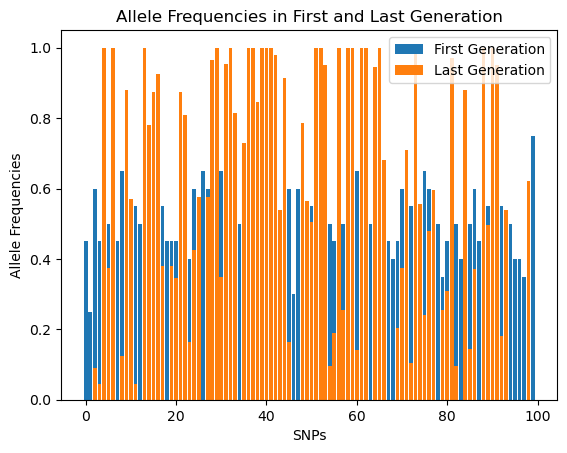

In [29]:
first_gen_freqs = allele_freqs[0]
last_gen_freqs = allele_freqs[-1]
x = np.arange(len(first_gen_freqs))
plt.bar(x = x, height = first_gen_freqs, label='First Generation')
plt.bar(x = x, height = last_gen_freqs, label='Last Generation')
plt.xlabel('SNPs')
plt.ylabel('Allele Frequencies')
plt.title('Allele Frequencies in First and Last Generation')
plt.legend()
plt.show()

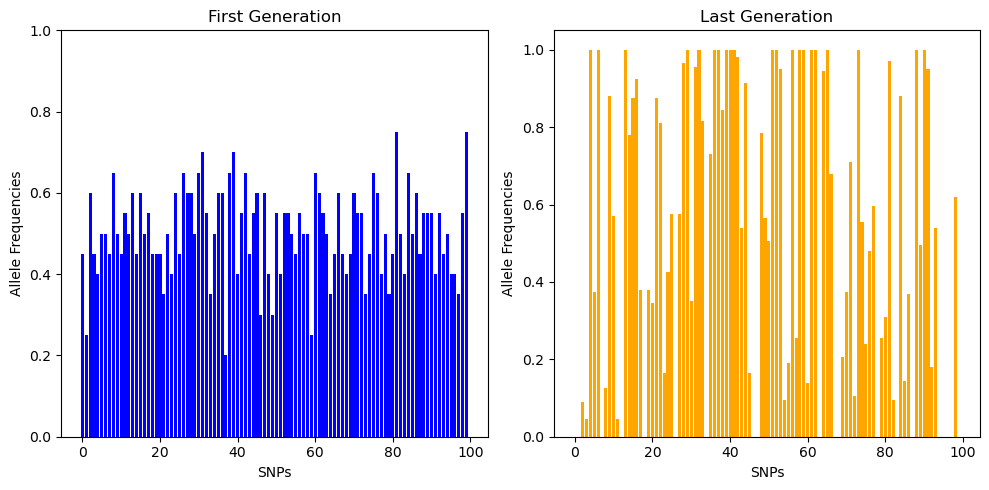

In [30]:
#like above, but plot the two generations in separate subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].bar(x = x, height = first_gen_freqs, color ='blue')
axs[0].set_ylim(0, 1)
axs[0].set_xlabel('SNPs')
axs[0].set_ylabel('Allele Frequencies')
axs[0].set_title('First Generation')
axs[1].bar(x = x, height = last_gen_freqs, color='orange')
axs[1].set_xlabel('SNPs')
axs[1].set_ylabel('Allele Frequencies')
axs[1].set_title('Last Generation')
plt.tight_layout()
plt.show()


In [31]:
#for both first_gen_freqs and last_gen_freqs, determine the number of SNPs with frequency 0 or 1
num_zero_freqs_first = np.sum(first_gen_freqs == 0)
num_zero_freqs_last = np.sum(last_gen_freqs == 0)
num_one_freqs_first = np.sum(first_gen_freqs == 1)
num_one_freqs_last = np.sum(last_gen_freqs == 1)
print("Population-homogeneous SNPs in first generation: ", num_zero_freqs_first + num_one_freqs_first)
print("Population-homogeneous SNPs in last generation: ", num_zero_freqs_last + num_one_freqs_last)

Population-homogeneous SNPs in first generation:  0
Population-homogeneous SNPs in last generation:  20


In [32]:
#run the above 10 times and take the average of the number of population-homogeneous SNPs
num_zero_freqs_first = []
num_zero_freqs_last = []
num_one_freqs_first = []
num_one_freqs_last = []

for i in range(10):
    final_mats, allele_freqs = simulate_genetic_recovery(n_init=10,
                                                        n_thriving=100,
                                                        num_snps=100,
                                                        dist_array=distance_array,
                                                        snp_mats=None)

    first_gen_freqs = allele_freqs[0]
    last_gen_freqs = allele_freqs[-1]

    num_zero_freqs_first.append(np.sum(first_gen_freqs == 0))
    num_zero_freqs_last.append(np.sum(last_gen_freqs == 0))
    num_one_freqs_first.append(np.sum(first_gen_freqs == 1))
    num_one_freqs_last.append(np.sum(last_gen_freqs == 1))

print("Average population-homogeneous SNPs in first generation: ", np.mean(num_zero_freqs_first) + np.mean(num_one_freqs_first))
print("Average population-homogeneous SNPs in last generation: ", np.mean(num_zero_freqs_last) + np.mean(num_one_freqs_last))

Average population-homogeneous SNPs in first generation:  0.0
Average population-homogeneous SNPs in last generation:  26.9
